In [1]:
# libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import CLIPProcessor, CLIPModel

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

from tqdm import tqdm
import config

/usr/local/Caskroom/miniconda/base/envs/EuroSAT/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Task 1: Zero-Shot Classification with Foundation Models

### Objective
The goal of this task is to explore the **EuroSAT dataset** and apply zero-shot classification using a **pre-trained CLIP model**. We will evaluate how well CLIP can classify satellite images using textual descriptions without any dataset-specific training.


## Data: EuroSAT Dataset

### Overview
The **EuroSAT dataset** consists of RGB satellite images categorized into 10 land cover classes. Let's analyze the structure.

Classes found: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Modified classes:  ['Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway', 'Industrial', 'Pasture', 'Permanent Crop', 'Residential', 'River', 'Sea Lake']
Class distribution: {'AnnualCrop': 3000, 'Forest': 3000, 'HerbaceousVegetation': 3000, 'Highway': 2500, 'Industrial': 2500, 'Pasture': 2000, 'PermanentCrop': 2500, 'Residential': 3000, 'River': 2500, 'SeaLake': 3000}


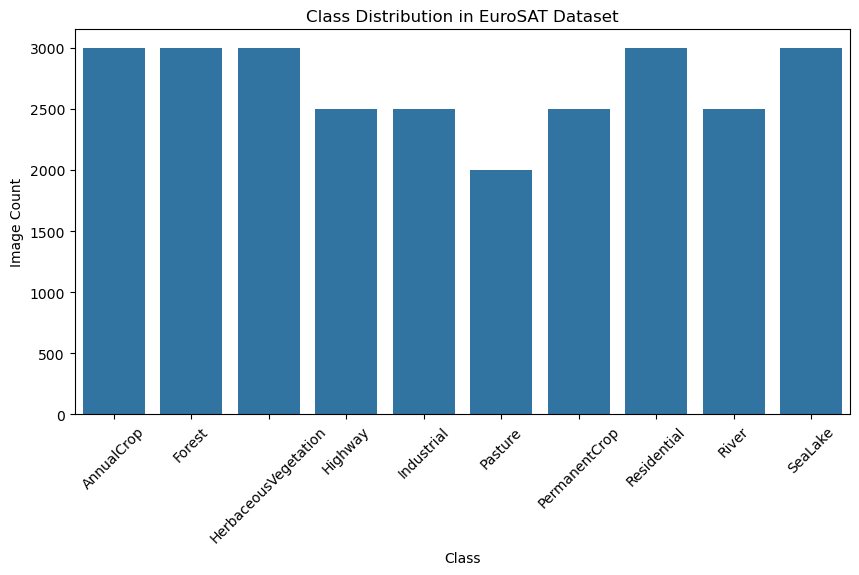

In [68]:
# classes check
dataset_path = "2750/"

CLASSES = sorted([cls for cls in os.listdir(dataset_path) if not cls.startswith('.')])
MOD_CLASSES = [config.CLASSNAME_DICT[c] for c in CLASSES]

print(f"Classes found: {CLASSES}")

print("Modified classes: ", MOD_CLASSES)

class_counts = {cls: len(glob(os.path.join(dataset_path, cls, "*.jpg"))) for cls in CLASSES}
print(f"Class distribution: {class_counts}")

df_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])

plt.figure(figsize=(10, 5))
sns.barplot(x="Class", y="Image Count", data=df_counts)
plt.xticks(rotation=45)
plt.title("Class Distribution in EuroSAT Dataset")
plt.show()


In [69]:
# channels and resolution check
image_info = []

for cls in CLASSES:
    img_path = glob(os.path.join(dataset_path, cls, "*.jpg"))[0]
    img = Image.open(img_path)
    image_info.append((cls, img.mode, img.size))

df_info = pd.DataFrame(image_info, columns=["Class", "Mode", "Resolution"])

print(df_info)

unique_modes = df_info["Mode"].unique()
unique_resolutions = df_info["Resolution"].unique()

print(f"\nUnique image modes found: {unique_modes}")
print(f"Unique image resolutions found: {unique_resolutions}")


                  Class Mode Resolution
0            AnnualCrop  RGB   (64, 64)
1                Forest  RGB   (64, 64)
2  HerbaceousVegetation  RGB   (64, 64)
3               Highway  RGB   (64, 64)
4            Industrial  RGB   (64, 64)
5               Pasture  RGB   (64, 64)
6         PermanentCrop  RGB   (64, 64)
7           Residential  RGB   (64, 64)
8                 River  RGB   (64, 64)
9               SeaLake  RGB   (64, 64)

Unique image modes found: ['RGB']
Unique image resolutions found: [(64, 64)]


#### **Dataset Structure**
- Folder: `2750/`
- Subfolders (each corresponding to a class):
  - `AnnualCrop/`
  - `Forest/`
  - `HerbaceousVegetation/`
  - `Highway/`
  - `Industrial/`
  - `Pasture/`
  - `PermanentCrop/`
  - `Residential/`
  - `River/`
  - `SeaLake/`
- Each subfolder contains from 2000 to 3000 images named as `{class_name}_{i}.jpg` (e.g., `Forest_102.jpg`). So overall the different classes are quite balanced.
- Images are repesentes as RGB satellite images with 64×64 pixels resolution.

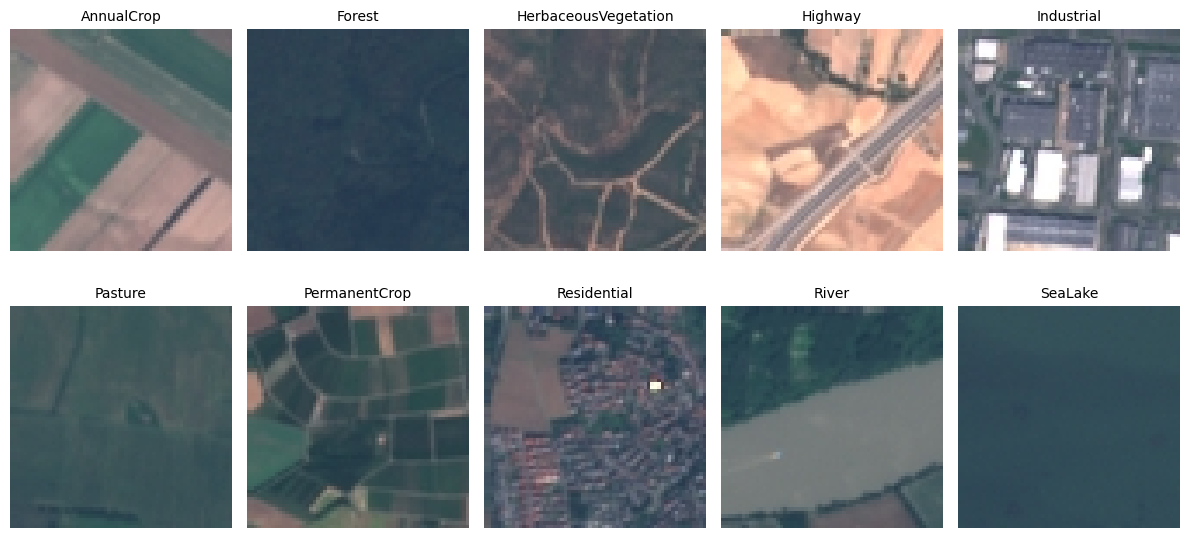

In [70]:
# visualization
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, cls in enumerate(CLASSES):
    img_path = glob(os.path.join(dataset_path, cls, "*.jpg"))[0]  
    img = Image.open(img_path)

    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.set_title(cls, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


Many of them looks quite similar such that it would be difficult to be classified for also for a human.

At the moment, "Highway" and "River" looks like may be confused, as well as the "Residential" and "Industrial" classes or the "AnnualCrop" and "Pasture".

## CLIP: Zero-Shot Classification with Foundation Models
In this section, we implement zero-shot classification using **CLIP** to classify EuroSAT satellite images without dataset-specific training.  

We start by defining a function that classifies a single image, ensuring efficiency and flexibility. Then, we apply it to a single class before running it on the entire dataset to evaluate performance across all land cover types.  

To determine the best approach, we test four configurations, varying image rescaling and prompting to analyze their impact on classification accuracy.


In [5]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = (
    torch.device("mps") if torch.backends.mps.is_available() else
    torch.device("cuda") if torch.cuda.is_available() else
    torch.device("cpu")
)
clip_model.to(device)
print("Device: ", device)


Device:  mps


In [71]:
class ImageDataset(Dataset):
    def __init__(self, root_dir):
        """
        Args:
            root_dir (str): Path to the dataset folder containing subfolders (each representing a class).
            classes (list, optional): List of class names to use. If None, all classes in root_dir are used.
        """
        self.root_dir = root_dir
        self.image_paths = []
        self.labels = []

        # If classes are not provided, infer from directory structure
        self.class_to_idx = {cls: idx for idx, cls in enumerate(CLASSES)}

        # Collect all image paths and labels
        for cls in CLASSES:
            class_dir = os.path.join(root_dir, cls)
            if os.path.isdir(class_dir):  # Ensure it's a directory
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
                        self.image_paths.append(os.path.join(class_dir, img_name))
                        self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        return img_path, label

    def get_class_subset(self, class_name):
        """Returns a subset of the dataset containing only images of the given class."""
        if class_name not in self.class_to_idx:
            raise ValueError(f"Class '{class_name}' not found in dataset. Available classes: {CLASSES}")

        class_idx = self.class_to_idx[class_name]
        subset_indices = [i for i, label in enumerate(self.labels) if label == class_idx]

        # Create a subset of the dataset
        subset = [(self.image_paths[i], self.labels[i]) for i in subset_indices]
        return subset


In [72]:
dataset = ImageDataset(dataset_path)  # root folder containing 10 subfolders
print(len(dataset))  # Total number of images

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

27000


### Single Image Classification 
We define a function that loads CLIP once and allows for customization:  
- **Resizing**: Optional rescaling to 224x224, CLIP’s expected input size.  
- **Prompting**: Either `"A satellite image of <class>"` or just the class name.  
- **Output Format**: Return either the best class or all probabilities for deeper analysis.  

These options allow us to test four setups, combining different prompts and rescaling choices to evaluate their impact on classification accuracy.


In [76]:
def classify_images_clip(
    image_paths, 
    full_prompt=True,  # "default" (uses "A satellite image of"), "none" (just class name)
    modify=False
):
    """
    Classifies a single image using CLIP in a zero-shot manner.

    Parameters:
    - image_path (str): Path to the image.
    - class_names (list): List of class labels.
    - prompt_type (str): "default" (adds 'A satellite image of') or "none" (just the class name).
    - rescale (bool): If True, rescale image to 224x224 (recommended for CLIP).
    - return_all (bool): If True, return all class probabilities; otherwise, return the best class.

    Returns:
    - If return_all=False: (str) Best class name.
    - If return_all=True: (dict) Class probabilities.
    """

    images = [Image.open(image_path).convert("RGB") for image_path in image_paths]

    if modify:
        class_names = MOD_CLASSES
    else:
        class_names = CLASSES
    text_inputs = [f"A satellite image of {cls}" for cls in class_names] if full_prompt else class_names

    inputs = clip_processor(text=text_inputs, images=images, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move to GPU if available

    with torch.no_grad():
        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)

    return probs.argmax(dim=-1)

    class_probs = {class_names[i]: probs[0, i].item() for i in range(len(class_names))}

    if return_all:
        return class_probs
    else:
        return max(class_probs, key=class_probs.get)

In [77]:
image_path = "2750/Forest/Forest_100.jpg"
best_class_index = classify_images_clip([image_path], CLASSES)
print(f"Predicted Class: {CLASSES[best_class_index]}")

Predicted Class: Forest


### Single-Class Analysis  
Before testing the full dataset, we apply CLIP to one class (`SeaLake`).  

We expect some correct classifications, but also errors due to CLIP's lack of satellite-specific training. This helps identify potential challenges before scaling up.

In [85]:
def single_class_analysis(class_name, full_prompt=True, modify=False):
    class_subset = dataset.get_class_subset(class_name)
    class_dataloader = DataLoader(class_subset, batch_size=64, shuffle=False)

    true_labels = []
    predicted_labels = []


    for img_paths, labels in tqdm(class_dataloader, desc=f"Classifying {class_name} batches: ", leave=True):
        true_labels.extend(labels)

        predictions = classify_images_clip(image_paths=img_paths, 
                                           full_prompt=full_prompt, 
                                           modify=modify).cpu()
        
        predicted_labels.extend(predictions)

    accuracy = accuracy_score(true_labels, predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels, labels=list(range(len(CLASSES))))
    
    return accuracy, cm

In [78]:
test_class_name = "SeaLake"

Classifying SeaLake batches: 100%|██████████| 47/47 [00:19<00:00,  2.43it/s]


Zero-Shot Classification Accuracy for 'SeaLake': 19.07%


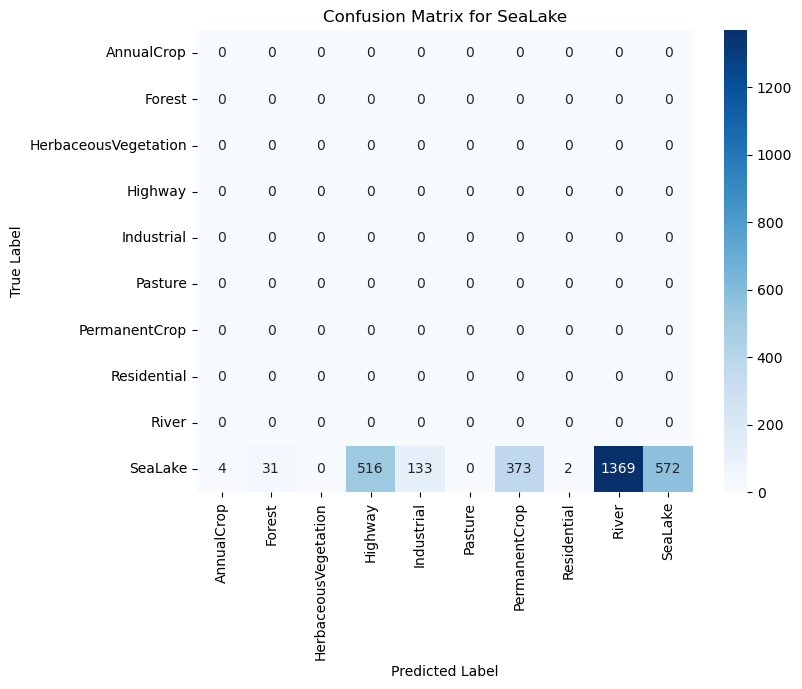

In [80]:
sealake_accuracy, sealake_cm = single_class_analysis(class_name=test_class_name, full_prompt=True, modify=False)

print(f"Zero-Shot Classification Accuracy for '{test_class_name}': {sealake_accuracy * 100:.2f}%")

plt.figure(figsize=(8, 6))
sns.heatmap(sealake_cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix for {test_class_name}")
plt.show()

### Whole Dataset Classification
We now classify the entire dataset using the four different configurations.  

By analyzing overall accuracy, per-class accuracy, and confusion matrices**, we aim to determine which approach works best for zero-shot land cover classification with CLIP.


In [81]:
def multi_class_analysis(full_prompt=True, modify=False):
    class_accuracies = {}
    class_cms = {}

    for eval_class in CLASSES:
        class_accuracy, class_cm = single_class_analysis(class_name=eval_class, full_prompt=full_prompt, modify=modify)

        class_accuracies[eval_class] = class_accuracy * 100
        class_cms[eval_class] = class_cm

    return class_accuracies, class_cms

#### 1) Full Context + Original Class Names

In [42]:
class_accuracies_1, class_cms_1 = multi_class_analysis(full_prompt=True, modify=False)

Classifying SeaLake batches: 100%|██████████| 47/47 [00:21<00:00,  2.16it/s]



Overall Accuracy (Full Prompt + Original Class Names): 38.29%

Accuracy per Class:
  - AnnualCrop: 13.77%
  - Forest: 39.80%
  - HerbaceousVegetation: 0.17%
  - Highway: 61.68%
  - Industrial: 72.44%
  - Pasture: 7.45%
  - PermanentCrop: 62.44%
  - Residential: 85.50%
  - River: 20.56%
  - SeaLake: 19.07%


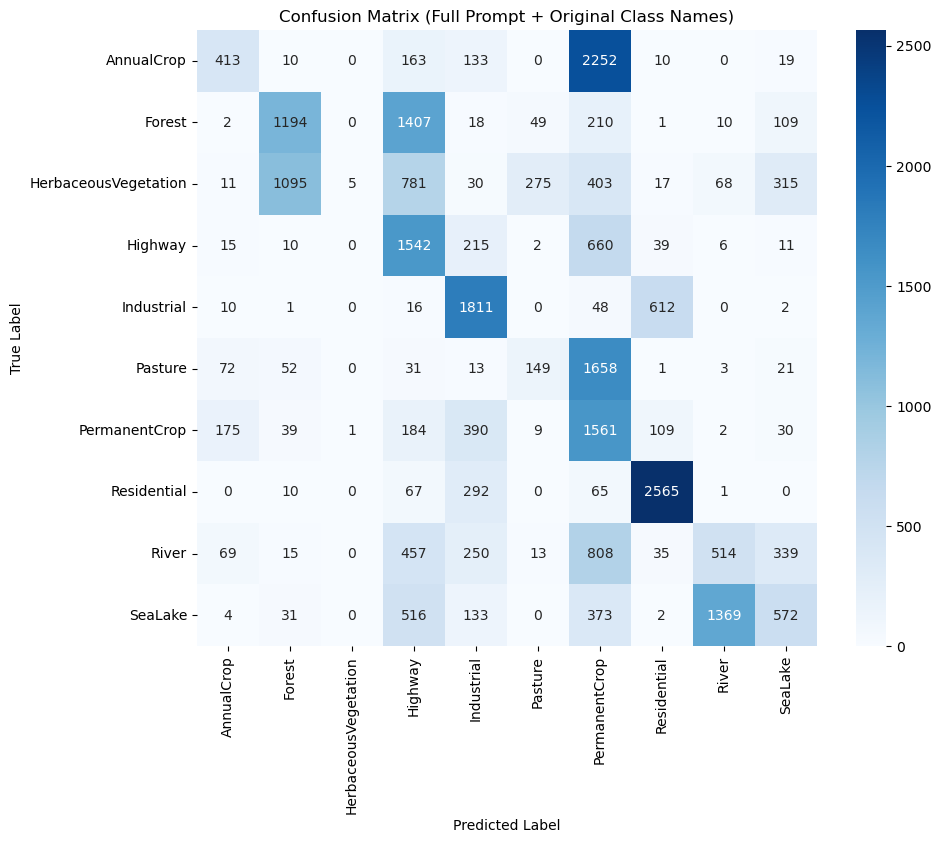

In [43]:
overall_accuracy = np.mean(list(class_accuracies_1.values()))
overall_cm = sum(list(class_cms_1.values()))

print(f"\nOverall Accuracy (Full Prompt + Original Class Names): {overall_accuracy:.2f}%\n")
print("Accuracy per Class:")
for cls, acc in class_accuracies_1.items():
    print(f"  - {cls}: {acc:.2f}%")

plt.figure(figsize=(10, 8))
sns.heatmap(overall_cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Full Prompt + Original Class Names)")
plt.show()


#### 2) No Context Prompt + Original Class Names

In [44]:
class_accuracies_2, class_cms_2 = multi_class_analysis(full_prompt=False, modify=False)

Classifying SeaLake batches: 100%|██████████| 47/47 [00:20<00:00,  2.26it/s]



Overall Accuracy (Full Prompt + Original Class Names): 35.18%

Accuracy per Class:
  - AnnualCrop: 28.63%
  - Forest: 17.00%
  - HerbaceousVegetation: 21.93%
  - Highway: 49.08%
  - Industrial: 4.48%
  - Pasture: 14.60%
  - PermanentCrop: 31.08%
  - Residential: 88.90%
  - River: 41.52%
  - SeaLake: 54.60%


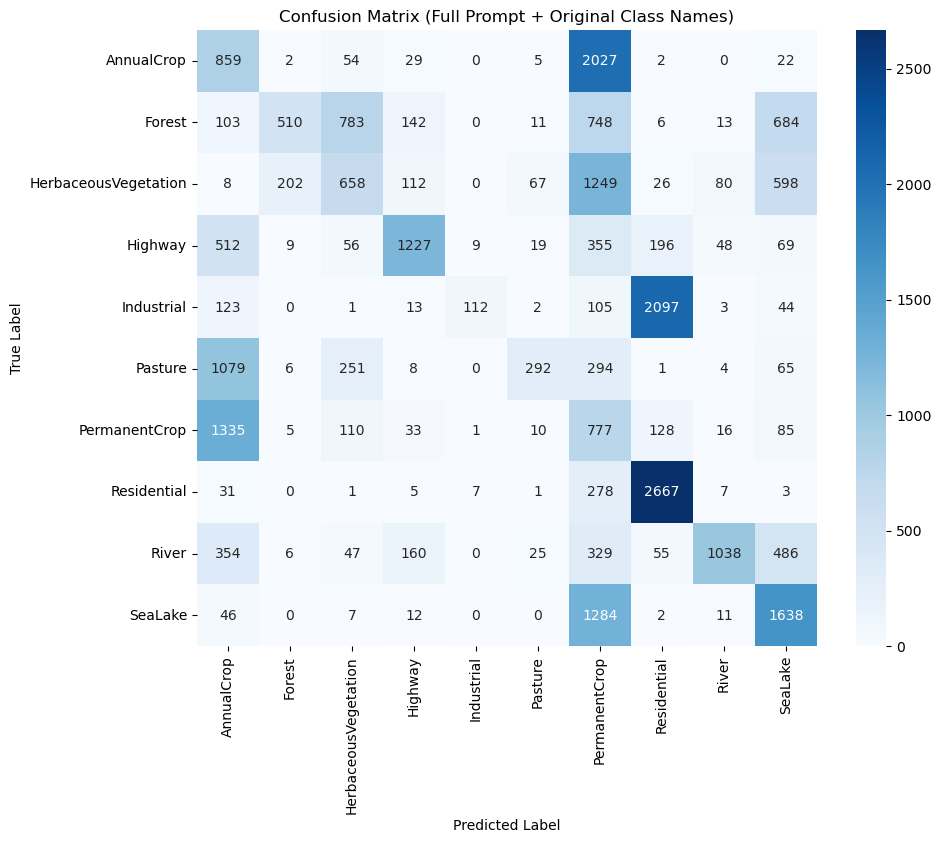

In [45]:
overall_accuracy = np.mean(list(class_accuracies_2.values()))
overall_cm = sum(list(class_cms_2.values()))

print(f"\nOverall Accuracy (Full Prompt + Original Class Names): {overall_accuracy:.2f}%\n")
print("Accuracy per Class:")
for cls, acc in class_accuracies_2.items():
    print(f"  - {cls}: {acc:.2f}%")

plt.figure(figsize=(10, 8))
sns.heatmap(overall_cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Full Prompt + Original Class Names)")
plt.show()


#### 3) Full Context with Modified Classes

In [47]:
class_accuracies_3, class_cms_3 = multi_class_analysis(full_prompt=True, modify=True)

Classifying AnnualCrop batches:   0%|          | 0/47 [00:00<?, ?it/s]

Classifying SeaLake batches: 100%|██████████| 47/47 [00:19<00:00,  2.47it/s]



Overall Accuracy (Full Context Prompt + Modified Class Names): 39.66%

Accuracy per Class:
  - AnnualCrop: 29.83%
  - Forest: 43.20%
  - HerbaceousVegetation: 0.07%
  - Highway: 68.16%
  - Industrial: 72.68%
  - Pasture: 39.85%
  - PermanentCrop: 25.32%
  - Residential: 86.40%
  - River: 25.04%
  - SeaLake: 6.03%


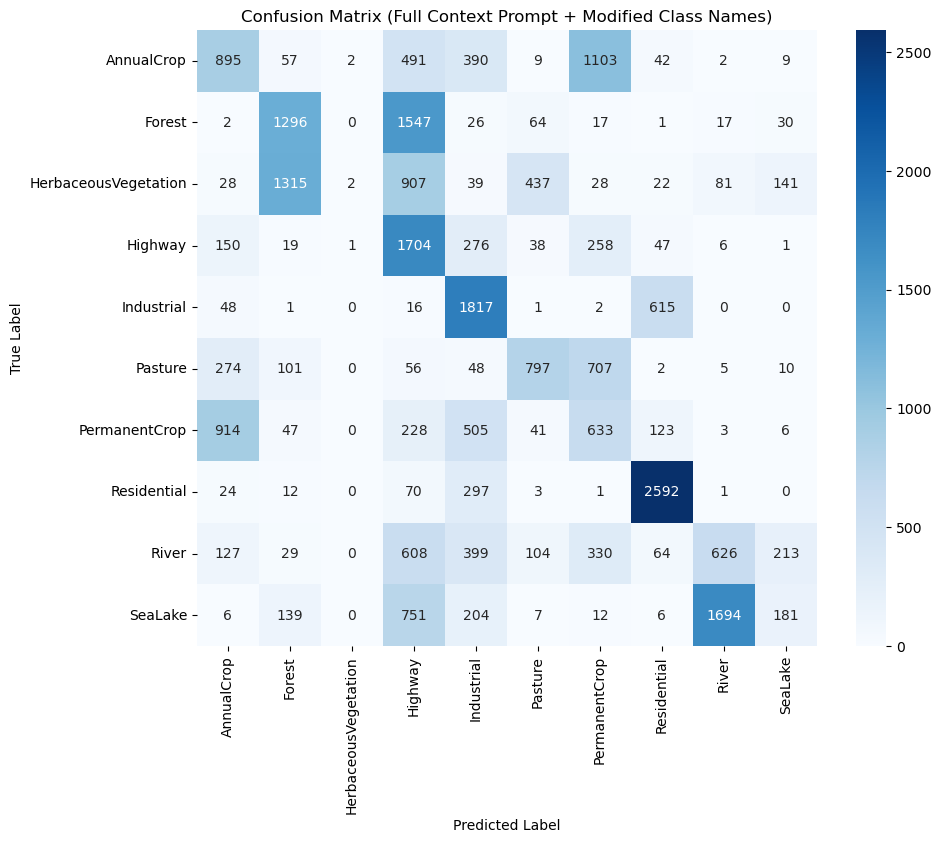

In [48]:
overall_accuracy = np.mean(list(class_accuracies_3.values()))
overall_cm = sum(list(class_cms_3.values()))

print(f"\nOverall Accuracy (Full Context Prompt + Modified Class Names): {overall_accuracy:.2f}%\n")
print("Accuracy per Class:")
for cls, acc in class_accuracies_3.items():
    print(f"  - {cls}: {acc:.2f}%")

plt.figure(figsize=(10, 8))
sns.heatmap(overall_cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Full Context Prompt + Modified Class Names)")
plt.show()


#### 4) No Context with Modified Classes

In [49]:
class_accuracies_4, class_cms_4 = multi_class_analysis(full_prompt=False, modify=True)

Classifying SeaLake batches: 100%|██████████| 47/47 [00:18<00:00,  2.58it/s]



Overall Accuracy (No Context Prompt + Modified Class Names): 35.45%

Accuracy per Class:
  - AnnualCrop: 0.10%
  - Forest: 42.00%
  - HerbaceousVegetation: 0.37%
  - Highway: 52.64%
  - Industrial: 6.08%
  - Pasture: 19.05%
  - PermanentCrop: 73.08%
  - Residential: 96.97%
  - River: 38.28%
  - SeaLake: 25.93%


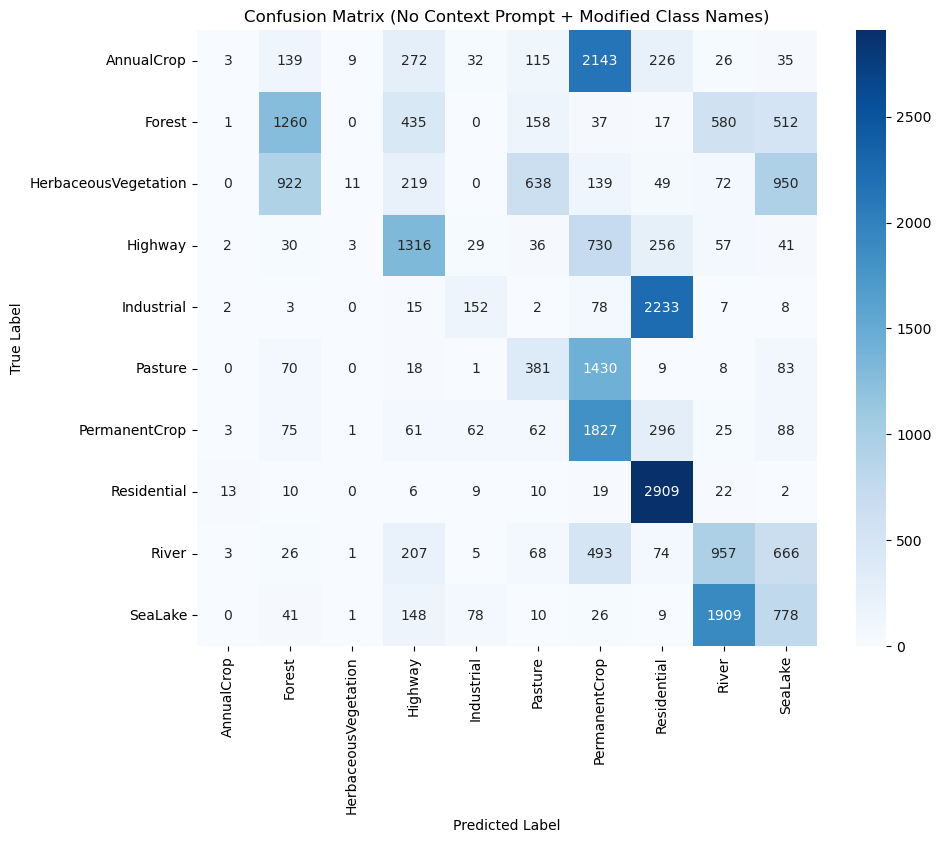

In [50]:
overall_accuracy = np.mean(list(class_accuracies_4.values()))
overall_cm = sum(list(class_cms_4.values()))

print(f"\nOverall Accuracy (No Context Prompt + Modified Class Names): {overall_accuracy:.2f}%\n")
print("Accuracy per Class:")
for cls, acc in class_accuracies_4.items():
    print(f"  - {cls}: {acc:.2f}%")

plt.figure(figsize=(10, 8))
sns.heatmap(overall_cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (No Context Prompt + Modified Class Names)")
plt.show()


#### Results Analysis

In [82]:
def compare_class_accuracies(accuracies, label_1="Config 1", label_2="Config 2"):
    """
    Compare accuracy results from two different configurations.

    Parameters:
    - acc_1: Dictionary of class accuracies for first configuration.
    - acc_2: Dictionary of class accuracies for second configuration.
    - label_1: Label for first configuration (string).
    - label_2: Label for second configuration (string).
    """

    acc_values = [[np.average([acc[cls] for cls in CLASSES])] + [acc[cls] for cls in CLASSES] for acc in accuracies]

    x = np.arange(len(CLASSES)+1)

    plt.figure(figsize=(24, 5))

    plt.bar(x - 0.3, acc_values[0], width=0.2, label="Full Prompt + Original Classnames", alpha=0.7)
    plt.bar(x - 0.1, acc_values[1], width=0.2, label="No Prompt + Original Classnames", alpha=0.7)
    plt.bar(x + 0.1, acc_values[2], width=0.2, label="Full Prompt + Modified Classnames", alpha=0.7)
    plt.bar(x + 0.3, acc_values[3], width=0.2, label="No Prompt + Modified Classnames", alpha=0.7)

    plt.xticks(x,  ["Average"] + CLASSES, rotation=45, ha="right")
    plt.ylabel("Accuracy (%)")
    plt.title(f"Comparison of Class Accuracies: {label_1} vs. {label_2}")
    plt.legend()
    plt.show()


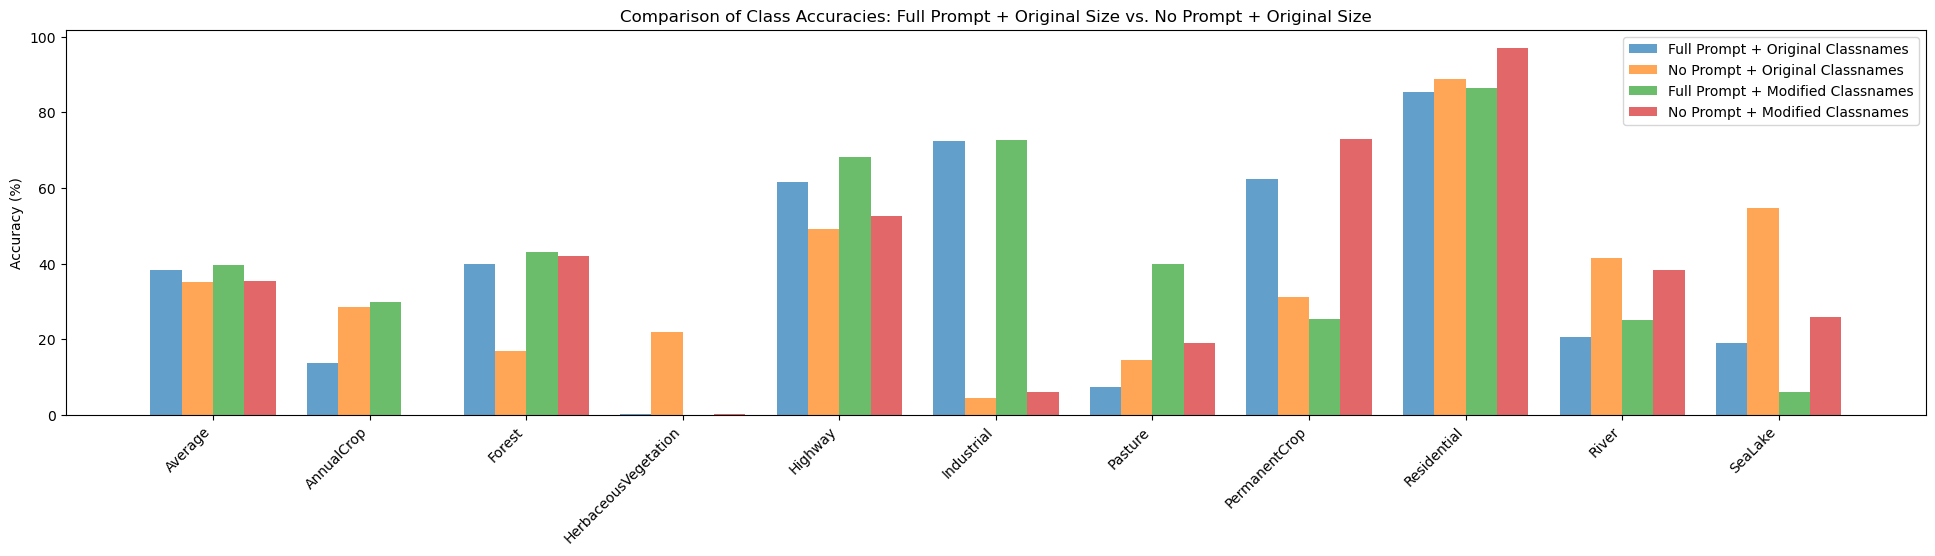

In [83]:
class_accuracies = [class_accuracies_1, class_accuracies_2, class_accuracies_3, class_accuracies_4]
compare_class_accuracies(class_accuracies, "Full Prompt + Original Size", "No Prompt + Original Size")

The results are quite interesting.

The average accuracies across each class are similar between the four strategies - with "Full Prompt + Modified Classnames" having a slight edge. However when we look into each of the classes, we can see some incredibly varying results. 

**Annual Crop**
- Virtually 0% with the 4th strategy
- 2nd and 3rd strategies similar (despite being 'opposite' strategies)

**Forest**
- Similar accuriacies around 40% for all strategies, besides 2nd which has below 20%

**Herbaceous Vegetation**
- Virtually 0% accuracy on all strategies except 2nd, which has above 20%

**Highway**
- Varied accuracies, seem to be favoring using the full prompt

**Industrial**
- Enormous dropoff in accuracies between strategies 1,3 and 2,4
- Favoring using full prompt

**Pasture** 
- Noticeable advantage to using 3rd strategy

**Permanent Crop** 
- Large dropoff in accuracies between strategies 1,4 and 2,3
- Advantage from using 'opposite' strategies

**Residential**
- Overall good accuracies, favor to strategy 4

It is curious that the improvements of some strategies on one class do not at all carry over to other classes. There are also huge discrepencies between some strategies in the same class, like **Herbacious Vegetation**. 

It is counter-intuitive that 'opposite' strategies show similar positive results in **Annual Crop** and **Permanent Crop**.
